# Analysis of Botswana MapBox Mobility Data

The purpose of this notebook is to visualize and assess the MapBox mobility data over Botswana for School and Non-School samples. The below analysis uses the hourly mobility data for October, November, December 2023.

MapBox Docs: https://docs.mapbox.com/data/movement/guides

The **Data Pre-Processing** section queries each school and non-school sample in the Botswana geojson cleaned schools file, generates a 300m buffer extent surrounding the school/non-school point and extracts the corresponding mobility data over that region. We cluster the data by Administrative Boundaries Level 1 and save the categorized data in the format of a dictionary of dataframes, saving via pickle. You can choose to go through each step of the data pre-processing to generate the dictionary of dataframes, or skip to the **Data Visualization** section to load the pickled dictionary and generate the plots.

## Imports and Setup

In [1]:
import os
import requests
from io import StringIO
import pandas as pd
import folium
from shapely.geometry import Point
import geopandas as gpd
from functools import partial
import pyproj
from shapely import geometry
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import transform
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import mercantile
from itertools import combinations
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sn
import pickle

## Loading Data

In [2]:
# Note: filepaths have been updated to Kelsey Doerksen's local machine until access re-instated
mobility_filepath = '/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility'

# Loading hourly mobility data
hourly_movement_df = pd.read_csv('{}/weekday-weekend-1hour.csv'.format(mobility_filepath))

# Loading 4-hour mobility day
day_of_week_4hour_df = pd.read_csv('{}/day_of_week-4hour.csv'.format(mobility_filepath))

# Loading BWA school geojson data
school_df = gpd.read_file('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/BWA_train.geojson')

## Data Pre-Processing
We would like to aggregate and analyze the activity associated with individual school and non-school samples.


### Adding Mobility Information

### Intersection Analysis
Only include mobility information if the school directly intersects with the available MapBox mobility data. we would like to spatially join the school/non-school point layer with the MapBox mobility polygon layer, retaining the point geometries and grabbing the attributes of the intersecting polygons (i.e. the activity data)

In [3]:
def get_polygon_from_tile(geography):
    """
    Converts the mercantile quadkey to polygon
    
    Args:
        df: dataframe 
    """
    tile = mercantile.quadkey_to_tile(str(geography))
    return Polygon(mercantile.feature(tile)['geometry']['coordinates'][0])

In [5]:
def add_mobility_data_intersection(movement_df, school_df):
    """
    Adds movement data to the school df
    """
    # Add mercantile tile as polygon to movement df
    movement_df['mercantile_polygon'] = movement_df['geography'].apply(get_polygon_from_tile)
    # Change name to geometry
    movement_df = movement_df.rename(columns={'mercantile_polygon': 'geometry'})
    # Transform mobility data to gpd
    movement_gdf = gpd.GeoDataFrame(movement_df, crs="EPSG:4326")
    
    if 'geo' in school_df.columns:
        school_df = school_df.rename(columns={'geo': 'geometry'})
        school_df.set_geometry("geometry")

    # Combine school/non-school samples with mobility data
    schools_with_mobility = school_df.sjoin(movement_gdf, how='left')

    # Drop if school does not intersect with available MapBox mobility data
    schools_with_mobility = schools_with_mobility.dropna(subset=["geography"])
    
    return schools_with_mobility

In [6]:
# Generate circular boundary around school at 300m radius
def aeqd_reproj_buffer(center, radius=300):
    """
    Converts center coordinates to AEQD projection,
    draws a circle of given radius around the center coordinates,
    converts both polygons back to original ESRI:54009
    
    Args:
        center center coordinates of the circle (derived from school location)
        radius (integer): circle's radius in meters.
    
    Returns:
        A shapely.geometry Polygon object for circle of given radius.
    """
    lat = center.y
    lon = center.x
    
    esri54009_to_epsg4326 = Transformer.from_crs("ESRI:54009", "EPSG:4326", always_xy=True)
    epsg4326_to_aeqd = Transformer.from_crs("EPSG:4326", "ESRI:54032")
    aeqd_to_epsg4326 = Transformer.from_crs("ESRI:54032", "EPSG:4326", always_xy=False)

    # Transform the center coordinates from 54009 to AEQD
    point_epsg4326 = Point(esri54009_to_epsg4326.transform(lon, lat))
    point_transformed = Point(epsg4326_to_aeqd.transform(point_epsg4326.x, point_epsg4326.y))
    
    # Get buffer of defined radius
    buffer = point_transformed.buffer(radius)
    
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_epsg4326.transform, buffer)
    
    return circle_poly

In [7]:
# Get a list of the mapbox data that is overlapping the radius extent we specified
def generate_quadkeys(circle_poly, zoom):
    """
    Generate a list of quadkeys that overlap our circles
    Args:
        circle_poly (shapely.geometry Polygon): circle polygon object drawn 
            around a school/non-school
        zoom (integer): zoom level.
        
    Return:
        List of quadkeys as string
    """
    return [mercantile.quadkey(x) for x in mercantile.tiles(*circle_poly.bounds, zoom)]

In [8]:
def add_movement_data_buffer(sample_df, mobility_df):
    """
    Adding mobility data based on quadkey intersections for buffer analysis
    """
    full_data = []
    for i in range(len(sample_df)):
        data_list = []
        for z18_quadkey in sample_df.loc[i]["z18_quadkeys"]:
            data_list.append(mobility_df[mobility_df["geography"] == int(z18_quadkey)])
        data_df = pd.concat(data_list)
        data_df['UID'] = sample_df.loc[i]['UID']
        data_df['name'] = sample_df.loc[i]['name']
        full_data.append(data_df)
    
    if full_data:
        full_df = pd.concat(full_data)
        return full_df

In [9]:
def add_movement_data(query_df, movement_df, month_subset, intersection_buffer):
    """
    Add movement data if MapBox quadkey exists
    Args:
        df: school/non-school df
        movement_df: MapBox mobility data df
        timeperiod: month of movement data to query
        intersection_buffer: buffer extent for intersection of mobility data surrounding school
        
    Return:
        df with movement data
    """
    date_dict = {
        'oct': '2023-10-01',
        'nov': '2023-11-01',
        'dec': '2023-12-01'
    }
    print('Running for date subset: {}'.format(month_subset))
    
    # Make a copy of the df so we can filter things
    movement_df_copy = movement_df.copy(deep=True)
    
    # Subset movement dict to the time we are interested in
    if not month_subset == 'all':
        movement_df_copy = movement_df_copy[movement_df["start_date"] == date_dict['{}'.format(month_subset)]]
    
    if intersection_buffer == 0:
        samples_with_mobility = add_mobility_data_intersection(movement_df_copy, query_df)
        if not month_subset == 'all':
            samples_with_mobility_date_subset = samples_with_mobility[samples_with_mobility["start_date"] == date_dict['{}'.format(month_subset)]]
        else:
            return samples_with_mobility
    else:
        # Run for buffer
        samples_with_mobility_date_subset = add_movement_data_buffer(query_df, movement_df_copy)
    
    return samples_with_mobility_date_subset

In [10]:
def calc_hourly_average_ai(df, time_period):
    """
    Aggregate movement data to hourly sum based on 
    quadkeys that interset with user-defined buffer
    and calculate the hourly average ai over 
    the time period for all of the samples
    time_period == 0: weekday
    time_period == 1: weekend
    """
    grouped = df.groupby(['UID', 'agg_day_period', 'agg_time_period', 'start_date', 'end_date'])
    sum_data = grouped.activity_index_total.sum()
    sum_df = sum_data.reset_index()
    
    
    hourly_df = sum_df[sum_df['agg_day_period'] == int(time_period)]
    UIDS = hourly_df['UID'].unique().tolist()
    data_list =[]
    for uid in UIDS:
        hourly_df_uid = hourly_df[hourly_df['UID'] == uid]
        time_periods = hourly_df_uid['agg_time_period'].unique().tolist()
        df_list = []
        for t in time_periods:
            df_new = pd.DataFrame()
            subset_df = hourly_df_uid[hourly_df_uid['agg_time_period'] == t]
            sum_ai = subset_df['activity_index_total'].sum()
            df_new['agg_time_period'] = [t]
            df_new['activity_index_total'] = [sum_ai]
            df_new['UID'] = [uid]
            df_list.append(df_new)
        df_combined = pd.concat(df_list)
        data_list.append(df_combined)
    
    if len(data_list) > 0:
        df_final= pd.concat(data_list)   
        mean_hourly_data = hourly_df.groupby(['agg_time_period']).activity_index_total.mean()
    else:
        mean_hourly_data = None
    
    return mean_hourly_data

In [11]:
def max_min_normalize(df):
    """
    max-min normalizing to compare
    data distributions
    """
    normalized_df = (df-df.min())/(df.max()-df.min())
    return normalized_df

## Clustering based on Location
From MapBox: The data for each country is normalized within that country. Comparisons made over short timescales and short distances are more trustworthy than those made over long timescales and distances. Comparisons made over areas that have a high average activity are more trustworthy than those made over areas that have low average activity.

Several clustering methods are shown below; K-Means, Admin Boundary Level2, and Admin Boundary Level1

In [ ]:
# Get school data as coords
coords = []
for i in range(len(school_df)):
    coords.append([school_df.loc[i].geometry.x, school_df.loc[i].geometry.y])

In [ ]:
# Using elbow method to determine number of clusters we should use
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
def add_cluster_id(df, n_clusters):
    """
    Add cluster id to dataframe
    """
    # From plot, we see 4 is the optimal cluster number
    kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 5,  max_iter=400, n_init=10)
    y_kmeans = kmeans.fit_predict(coords)
    k=pd.DataFrame(y_kmeans, columns=['cluster'])
    
    # add cluster class to school dataframe
    df_with_cluster = school_df.join(k)
    
    return df_with_cluster

In [ ]:
# Add cluster id to dataframe
school_df_with_clusters = add_cluster_id(school_df, 4)

In [ ]:
filtered_label0 = school_df_with_clusters[school_df_with_clusters['cluster'] == 0]
filtered_label1 = school_df_with_clusters[school_df_with_clusters['cluster'] == 1]
filtered_label2 = school_df_with_clusters[school_df_with_clusters['cluster'] == 2]
filtered_label3 = school_df_with_clusters[school_df_with_clusters['cluster'] == 3]

plt.scatter(filtered_label0.geometry.x, filtered_label0.geometry.y, label='Cluster 0')
plt.scatter(filtered_label1.geometry.x, filtered_label1.geometry.y, label='Cluster 1')
plt.scatter(filtered_label2.geometry.x, filtered_label2.geometry.y, label='Cluster 2')
plt.scatter(filtered_label3.geometry.x, filtered_label3.geometry.y, label='Cluster 3')
plt.legend()
plt.title('K-Means Clustered School and Non-school samples')
plt.show()

## Clustering via administrative boundaries
We can also cluster via administrative boundaries, let's do this and see how many clusters we get, combining very small clusters together as MapBox notes that this is an ineffective way to analyze data

In [12]:
def cluster_via_adm(sample_df, adm_level):
    """
    Function to cluster data via ADM boundaries
    :param: sample_df: df of school and non-school samples to cluster
    :param: adm_level: administrative level to query for generating clusters
    """
    # Load country admin levels
    country_adm_levels = gpd.read_file('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/geoBoundaries-BWA-ADM{}.geojson'.format(adm_level))
    
    # Transform sample df to EPSG4326
    sample_df_epsg4326 = sample_df.to_crs('EPSG:4326')
    
    # Get intersection of sample df with admin boundaries
    sample_df_with_intersections = gpd.overlay(sample_df_epsg4326, country_adm_levels, how='intersection')
    
    # Plot clusters to observe
    clusters = sample_df_with_intersections ['shapeName'].unique()
    plt. figure(figsize=(8, 6))
    for i in range(len(clusters)):
        filt = sample_df_with_intersections [sample_df_with_intersections ['shapeName'] == clusters[i]]
        plt.scatter(filt.geometry.x, filt.geometry.y, label=clusters[i])

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Botswana ADM{} Boundary School/Non-School Sample Clustering'.format(adm_level))
    plt.show()
    
    return sample_df_with_intersections

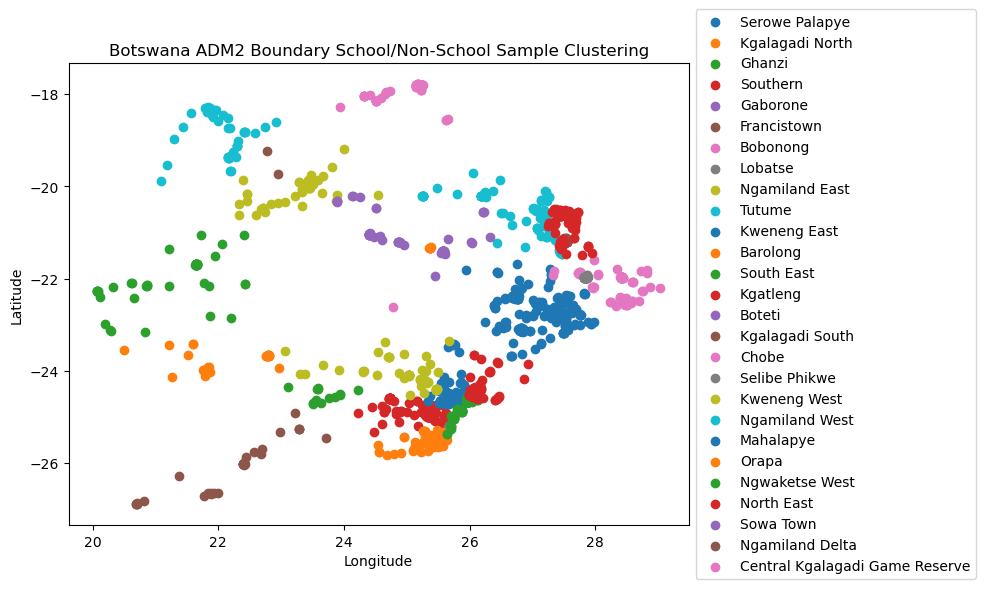

In [13]:
# Clustering based on ADM2
school_df_with_clusters_adm2 = cluster_via_adm(school_df, 2)

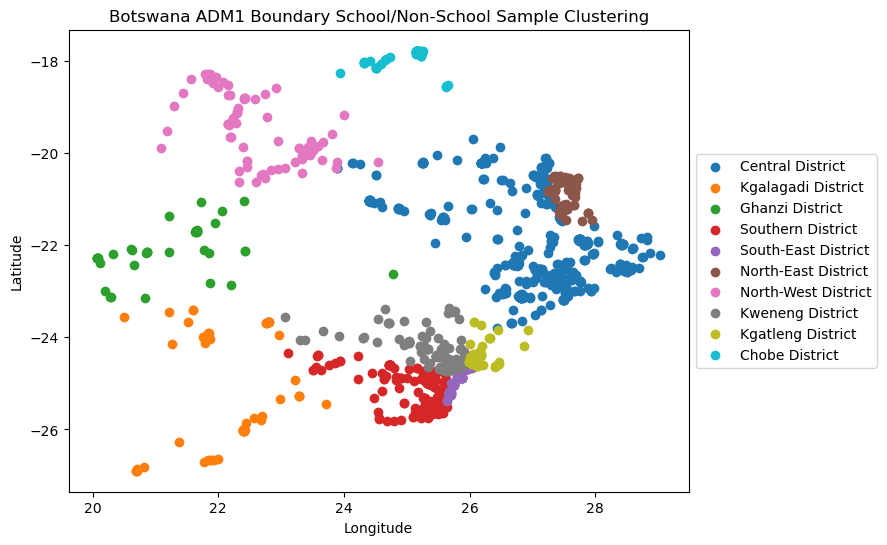

In [14]:
# Clustering based on ADM1
school_df_with_clusters = cluster_via_adm(school_df, 1)

Looking at above clustering methods, clustering via adminstrative boundaries level 2 may result in too small of sample sizes, which will result in our Mobility analysis not being meaningful. **We will proceed with Admin Boundaries 1 clustering**

### School and Non-School Sample Selection
For initial demo, 3 schools and non-schools are selected randomly via QGIS manual inspection in rural and urban areas based on the definition in the BWA_train.gejson file. 

Non-Schools are selected by finding a close non-school point to a school point.

The definitions of each type of non-school are from their UID is:

Urban:
- OSM-BWA-NON_SCHOOL-00000835: Cloud Networks Business Center
- OSM-BWA-NON_SCHOOL-00000849: Mmopane Police
- OVERTURE-BWA-NON_SCHOOL-00000420: Mbizi Guest House Sebina

Rural: 
- OSM-BWA-NON_SCHOOL-00000813: Bokspits Clinic
- OSM-BWA-NON_SCHOOL-00000561: Sanitary Checkpoint
- OSM-BWA-NON_SCHOOL-00000027: Game Scouts - Park Entry


In [ ]:
# Uncomment if you would like to only run on a small subset of the schools

# Subsetting data into rural-school, rural-nonschool, urban-school, urban-nonschool
# Samples selected based on visiual inspection in QGIS 
'''
urban_schools_subset = ['OSM-BWA-SCHOOL-00000103', 'OSM-BWA-SCHOOL-00000152', 'UNICEF-BWA-SCHOOL-00000048']
rural_schools_subset = ['UNICEF-BWA-SCHOOL-00000335', 'UNICEF-BWA-SCHOOL-00000683', 'UNICEF-BWA-SCHOOL-00000096']
urban_non_schools_subset = ['OSM-BWA-NON_SCHOOL-00000835', 'OSM-BWA-NON_SCHOOL-00000849', 'OVERTURE-BWA-NON_SCHOOL-00000420']
rural_non_schools_subset = ['OSM-BWA-NON_SCHOOL-00000813', 'OSM-BWA-NON_SCHOOL-00000561', 'OSM-BWA-NON_SCHOOL-00000027']

rural_school_df = school_df.copy(deep=True)[school_df['UID'].isin(rural_schools)]
urban_school_df = school_df.copy(deep=True)[school_df['UID'].isin(urban_schools)]
rural_nonschool_df = school_df.copy(deep=True)[school_df['UID'].isin(rural_non_schools)]
urban_nonschool_df = school_df.copy(deep=True)[school_df['UID'].isin(urban_non_schools)]
'''

In [21]:
# Subset into school and nonschool
school_samples_df = school_df_with_clusters.copy(deep=True)[school_df_with_clusters['class'] == 'school']
nonschool_samples_df = school_df_with_clusters.copy(deep=True)[school_df_with_clusters['class'] == 'non_school']

## Dictionary Functions
Below functions are used to generate the cluster dictionary based on the defined categories for schools and non-schools for subsetting the data

In [15]:
def generate_cluster_dict(cluster_name, school_df, nonschool_df):
    """
    Creates a dictionary of relevant dfs per cluster
    :param: cluster_name: cluster id
    :param: school_df: df of school samples
    :param: nonschool_df: df of non-school samples
    
    :return: dictionary of dataframes for the cluster
    """
    cluster_dict = {}
    cluster_dict['schools'] = school_df[school_df['shapeName'] == cluster_name].reset_index().drop(columns=['index'])
    cluster_dict['nonschools'] = nonschool_df[nonschool_df['shapeName'] == cluster_name].reset_index().drop(columns=['index'])
    
    # Defining building types for non-schools (to update to not have to make case sensitive)
    clinics = ['clinic', 'hospital', 'health', 'medical', 'Clinic', 'Hospital', 'Health', 'Medical']
    police = ['police', 'Police']
    farm = ['farm', 'Farm']
    
    # Dropping samples with no names for nonschools as we can't identify these by category
    nonschools_no_nan = nonschool_df.dropna(subset=['name'])
    
    # Adding filtered non-schools for cluster to dictionary
    cluster_dict['clinics'] = filter_df(nonschools_no_nan, clinics)
    cluster_dict['police'] = filter_df(nonschools_no_nan, police)
    cluster_dict['farms'] = filter_df(nonschools_no_nan, farm)
    
    # Subset for urban and rural schools
    cluster_dict['urban_schools'] = school_df[school_df['rurban'] == 'urban'].reset_index().drop(columns=['index'])
    cluster_dict['rural_schools'] = school_df[school_df['rurban'] == 'rural'].reset_index().drop(columns=['index'])
    
    # Subset for urban and rural nonschools
    cluster_dict['urban_nonschools'] = nonschool_df[nonschool_df['rurban'] == 'urban'].reset_index().drop(columns=['index'])
    cluster_dict['rural_nonschools'] = nonschool_df[nonschool_df['rurban'] == 'rural'].reset_index().drop(columns=['index'])
    
    return cluster_dict

In [16]:
# Loop through dataframes per cluster and add movement data, then normalize
def generate_hourly_movement_per_cluster(cluster_dict, cluster_id, intersection):
    """
    Generate a dictionary for cluster specified of 
    normalized hourly movement data
    :param: cluster_dict: dictionary of dataframes per cluster
    :param: cluster_id: cluster id
    :param: intersection: integer representing buffer extent, if 0, represents direct intersection
    :return: dictionary of hourly weekday and weekend mobility data
    """
    mobility_cluster_dict = {'oct': None, 'nov': None, 'dec': None, 'all': None}
    dates = ['oct', 'nov', 'dec', 'all']
    for date in dates:
        date_dict = {}
        for key in cluster_dict.keys():
            df = cluster_dict[key]
            print('Running for key: {}'.format(key))
            df_with_movement = add_movement_data(df, hourly_movement_df, date, intersection)
            movement_hourly_weekday = calc_hourly_average_ai(df_with_movement, 0)
            movement_hourly_weekend = calc_hourly_average_ai(df_with_movement, 1)
            
            # normalize so we can cross-compare regions
            if movement_hourly_weekday is not None:
                movement_hourly_weekday_norm = max_min_normalize(movement_hourly_weekday)
            else:
                movement_hourly_weekday_norm = None
            if movement_hourly_weekend is not None:
                movement_hourly_weekend_norm = max_min_normalize(movement_hourly_weekend)
            else:
                movement_hourly_weekend_norm = None
            
            date_dict['{}_hourly_weekday_ai'.format(key)] = movement_hourly_weekday_norm
            date_dict['{}_hourly_weekend_ai'.format(key)] = movement_hourly_weekend_norm
        mobility_cluster_dict[date] = date_dict
    
    return mobility_cluster_dict

In [17]:
# Loop through dataframes per cluster and add movement data, then normalize
def add_movement_per_cluster(cluster_dict, cluster_id, intersection):
    """
    Generate dictionary of movement data
    :param: cluster_dict: dictionary of dataframes per cluster
    :param: cluster_id: cluster id
    :param: intersection: integer representing buffer extent, if 0, represents direct intersection
    :return: dictionary of hourly weekday and weekend mobility data
    """
    mobility_cluster_dict = {'oct': None, 'nov': None, 'dec': None, 'all': None}
    dates = ['oct', 'nov', 'dec', 'all']
    for date in dates:
        date_dict = {}
        for key in cluster_dict.keys():
            df = cluster_dict[key]
            print('Running for key: {}'.format(key))
            df_with_movement = add_movement_data(df, hourly_movement_df, date, intersection)
            df_with_movement_weekday = df_with_movement[df_with_movement['agg_day_period'] == 0]
            df_with_movement_weekend = df_with_movement[df_with_movement['agg_day_period'] == 1]
            
            date_dict['{}_weekday_ai'.format(key)] = df_with_movement_weekday
            date_dict['{}_weekend_ai'.format(key)] = df_with_movement_weekend
        mobility_cluster_dict[date] = date_dict
    
    return mobility_cluster_dict

In [18]:
def filter_df(df, filter_list):
    """
    Filter df based on filtering list criteria
    """
    df_list = []
    for criteria in filter_list:
        filt_df = df[df['name'].str.contains(criteria)]
        filt_df = filt_df.rename(columns={"geometry": "geo"})
        df_list.append(filt_df)
    
    combined_df = pd.concat(df_list, axis=0, ignore_index=True)
    return combined_df

## Plotting Function(s)

In [19]:
# Plotting function
def plot_activity_index(df, cluster_name, category, time, marker='off'):
    """
    Function to plot activity index. 
    Call plt.show() after function
    :param df: dataframe of activity data
    :param cluster_name: name of cluster 
    :param category: category of df, i.e school, non-school, clinic, etc.
    :param time: weekday or weekend
    :param marker: specify if markers that represent number of measurements to be included in plot
    """
    plt.plot(df, label='{} Hourly Activity'.format(category))
    plt.xlabel('Hour of Day')
    plt.ylabel('Activity Index')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('{} {} Activity'.format(cluster_name, time))

# Intersection Analysis 4 Clusters

In [ ]:
school_samples_df = school_samples_df.rename(columns={'cluster': 'shapeName'})
nonschool_samples_df = nonschool_samples_df.rename(columns={'cluster': 'shapeName'})
school_df_with_clusters = school_df_with_clusters.rename(columns={'cluster': 'shapeName'})

In [38]:
school_df_with_clusters = school_df_with_clusters.to_crs('EPSG:4326')
school_samples_df = school_samples_df.to_crs('EPSG:4326')
nonschool_samples_df = nonschool_samples_df.to_crs('EPSG:4326')

In [39]:
# Create cluster dictionaries
cluster_names = school_df_with_clusters['shapeName'].unique()
data_dict = {}
for name in cluster_names:
    data_dict['{}'.format(name)] = generate_cluster_dict(name, school_samples_df, nonschool_samples_df)

In [73]:
pickle.dump(data_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_unfiltered_mobility_dfs_4clusters.p", "wb" ))

In [ ]:
# Generate mobility clusters
data_mobility_dict = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict['{}'.format(key)] = generate_hourly_movement_per_cluster(data_dict[key], key, 0)

In [43]:
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs_4clusters.p", "wb" ))

## Data Visualization

In [44]:
# Loading pickled data
data_mobility_dict_inter = pickle.load(open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs_4clusters.p", "rb"))

In [45]:
cluster_id = '1'

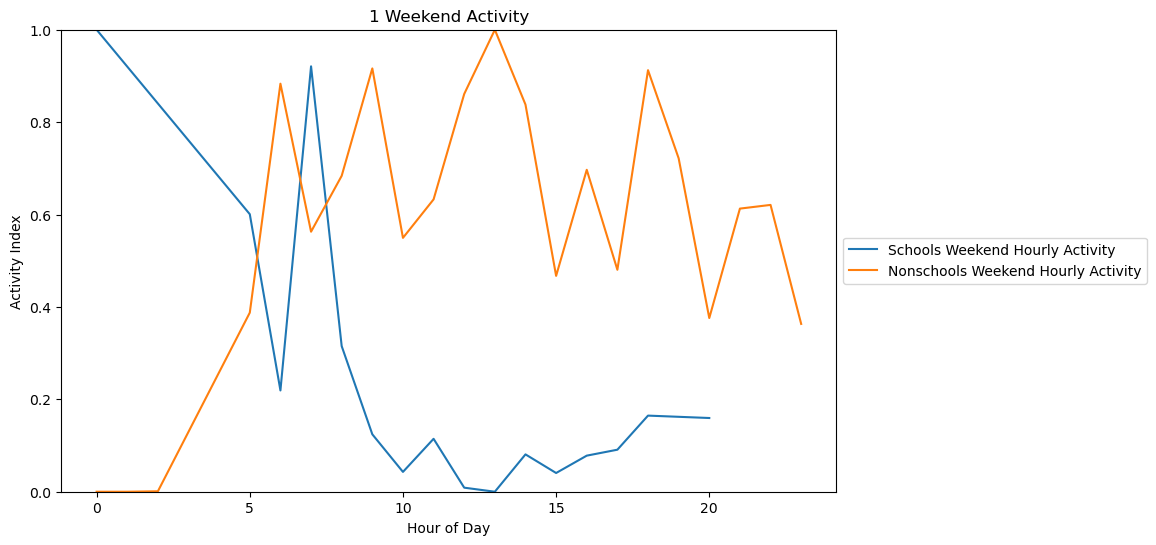

In [58]:
# Plotting weekend activity of schools, nonschools October
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict_inter[cluster_id]['oct']['schools_hourly_weekend_ai'], cluster_id, 'Schools Weekend', 'Weekend')
plot_activity_index(data_mobility_dict_inter[cluster_id]['oct']['nonschools_hourly_weekend_ai'], cluster_id, 'Nonschools Weekend', 'Weekend')
plt.show()

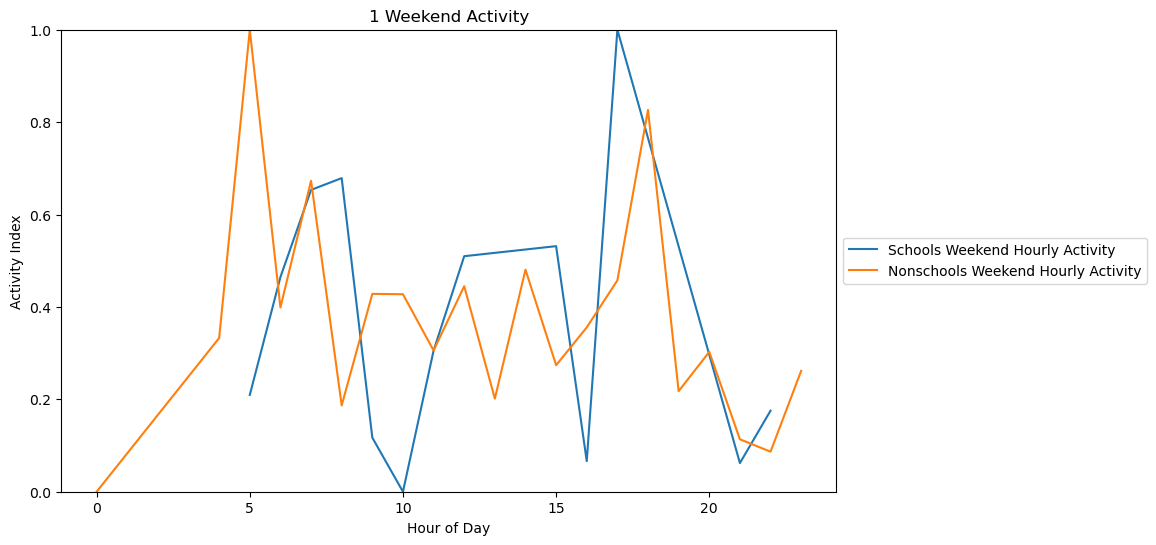

In [59]:
# Plotting weekend activity of schools, nonschools November
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict_inter[cluster_id]['nov']['schools_hourly_weekend_ai'], cluster_id, 'Schools Weekend', 'Weekend')
plot_activity_index(data_mobility_dict_inter[cluster_id]['nov']['nonschools_hourly_weekend_ai'], cluster_id, 'Nonschools Weekend', 'Weekend')
plt.show()

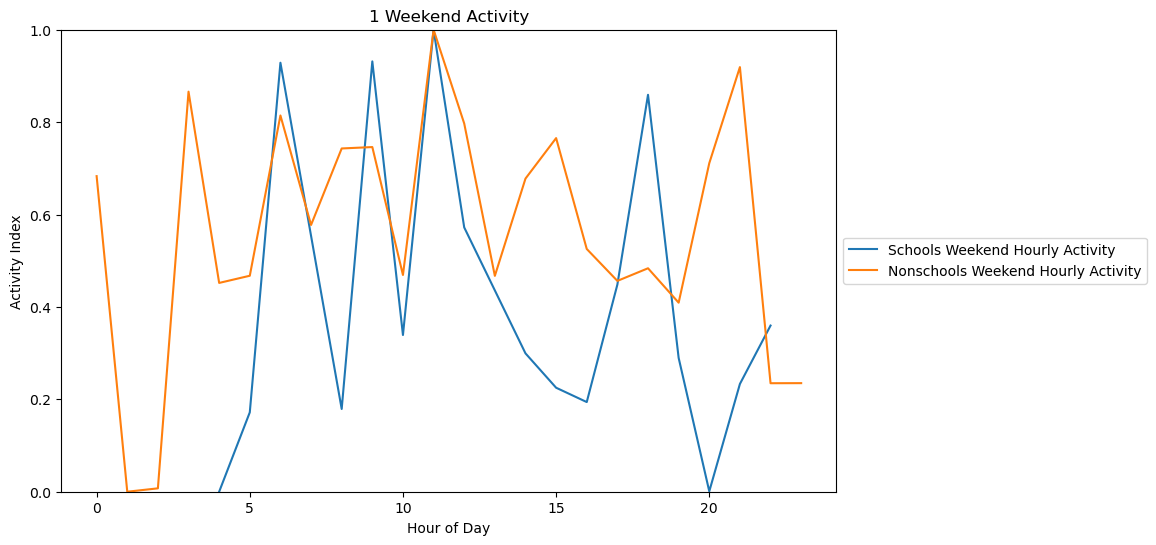

In [60]:
# Plotting weekend activity of schools, nonschools December
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict_inter[cluster_id]['dec']['schools_hourly_weekend_ai'], cluster_id, 'Schools Weekend', 'Weekend')
plot_activity_index(data_mobility_dict_inter[cluster_id]['dec']['nonschools_hourly_weekend_ai'], cluster_id, 'Nonschools Weekend', 'Weekend')
plt.show()

# Intersection Analysis ADM2 Clusters
Below analysis is for using only the MapBox data for which the school/non-school samples directly overlap the z18 quadkey tile for

In [22]:
# Create cluster dictionaries
cluster_names = school_df_with_clusters['shapeName'].unique()
data_dict = {}
for name in cluster_names:
    data_dict['{}'.format(name)] = generate_cluster_dict(name, school_samples_df, nonschool_samples_df)

In [ ]:
# Generate mobility clusters
data_mobility_dict = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict['{}'.format(key)] = generate_hourly_movement_per_cluster(data_dict[key], key, 0)

In [ ]:
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs.p", "wb" ))

In [ ]:
# Generating mobility clusters without aggregation to down-select several samples
# Generate mobility clusters
data_mobility_dict_no_agg = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict_no_agg['{}'.format(key)] = add_movement_per_cluster(data_dict[key], key, 0)

Running for key: Central District
Running for key: schools
Running for date subset: oct
Running for key: nonschools
Running for date subset: oct
Running for key: clinics
Running for date subset: oct
Running for key: police
Running for date subset: oct
Running for key: farms
Running for date subset: oct
Running for key: urban_schools
Running for date subset: oct
Running for key: rural_schools
Running for date subset: oct
Running for key: urban_nonschools
Running for date subset: oct
Running for key: rural_nonschools
Running for date subset: oct
Running for key: schools
Running for date subset: nov
Running for key: nonschools
Running for date subset: nov
Running for key: clinics
Running for date subset: nov
Running for key: police
Running for date subset: nov
Running for key: farms
Running for date subset: nov
Running for key: urban_schools
Running for date subset: nov
Running for key: rural_schools
Running for date subset: nov
Running for key: urban_nonschools
Running for date subset: n

Running for key: rural_schools
Running for date subset: all
Running for key: urban_nonschools
Running for date subset: all
Running for key: rural_nonschools
Running for date subset: all
Running for key: South-East District
Running for key: schools
Running for date subset: oct
Running for key: nonschools
Running for date subset: oct
Running for key: clinics
Running for date subset: oct
Running for key: police
Running for date subset: oct
Running for key: farms
Running for date subset: oct
Running for key: urban_schools
Running for date subset: oct
Running for key: rural_schools
Running for date subset: oct
Running for key: urban_nonschools
Running for date subset: oct
Running for key: rural_nonschools
Running for date subset: oct
Running for key: schools
Running for date subset: nov
Running for key: nonschools
Running for date subset: nov
Running for key: clinics
Running for date subset: nov
Running for key: police
Running for date subset: nov
Running for key: farms
Running for date sub

Running for key: police
Running for date subset: all
Running for key: farms
Running for date subset: all
Running for key: urban_schools
Running for date subset: all
Running for key: rural_schools
Running for date subset: all
Running for key: urban_nonschools
Running for date subset: all
Running for key: rural_nonschools
Running for date subset: all
Running for key: Kgatleng District
Running for key: schools
Running for date subset: oct
Running for key: nonschools
Running for date subset: oct
Running for key: clinics
Running for date subset: oct
Running for key: police
Running for date subset: oct
Running for key: farms
Running for date subset: oct
Running for key: urban_schools
Running for date subset: oct
Running for key: rural_schools
Running for date subset: oct
Running for key: urban_nonschools
Running for date subset: oct
Running for key: rural_nonschools
Running for date subset: oct
Running for key: schools
Running for date subset: nov
Running for key: nonschools
Running for date

In [ ]:
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict_no_agg, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs_no_agg.p", "wb" ))

## Data Visualization

In [ ]:
# Loading pickled data
data_mobility_dict_inter = pickle.load(open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs.p", "rb"))

In [ ]:
cluster_id = 'Kweneng District'

In [ ]:
# Plotting weekend activity of schools, nonschools October
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict_inter[cluster_id]['oct']['schools_hourly_weekend_ai'], cluster_id, 'Schools Weekend', 'Weekend')
plot_activity_index(data_mobility_dict_inter[cluster_id]['oct']['nonschools_hourly_weekend_ai'], cluster_id, 'Nonschools Weekend', 'Weekend')
plt.show()

In [ ]:
# Plotting weekend activity of schools, nonschools November
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict_inter[cluster_id]['nov']['schools_hourly_weekend_ai'], cluster_id, 'Schools Weekend Nov', 'Weekend')
plot_activity_index(data_mobility_dict_inter[cluster_id]['nov']['nonschools_hourly_weekend_ai'], cluster_id, 'Nonschools Weekend Nov', 'Weekend')
plt.show()

In [ ]:
# Plotting weekend activity of schools, nonschools December
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict_inter[cluster_id]['dec']['schools_hourly_weekend_ai'], cluster_id, 'Schools Weekend Nov', 'Weekend')
plot_activity_index(data_mobility_dict_inter[cluster_id]['dec']['nonschools_hourly_weekend_ai'], cluster_id, 'Nonschools Weekend Nov', 'Weekend')
plt.show()

# Buffer Analysis

1. Define 300m boundary for each school/non-school sample
2. Get a list of MapBox quadkey tiles that overlap school/non-school buffer zone
3. Take summary statistics of MapBox movement data

In [ ]:
# Get circle buffer and add to school_df
school_df['aeqd_reproj_circle'] = school_df['geometry'].apply(aeqd_reproj_buffer)

In [ ]:
# Add zoom level 18 quadkeys to school dataset
school_df['z18_quadkeys'] = school_df.apply(lambda x: generate_quadkeys(x['aeqd_reproj_circle'], 18),axis=1)

### Subset Non-Schools based on building type
We know that our ML models struggle with False Positives on samples represented by hospitals & clinics, police stations and farmsteads. In theory, the activity level around these types of buildings vs schools should be different, so we would like to subset the samples by these categories to observe

In [ ]:
# Dropping nans from samples because we can't associate them with building type if not defined
school_df_no_nan = nonschool_samples_df.dropna(subset=['name'])

In [ ]:
# Defining building types for non-schools (to update to not have to make case sensitive)
clinics = ['clinic', 'hospital', 'health', 'medical', 'Clinic', 'Hospital', 'Health', 'Medical']
police = ['police', 'Police']
farm = ['farm', 'Farm']

In [ ]:
clinic_df = filter_df(school_df_no_nan, clinics)
police_df = filter_df(school_df_no_nan, police)
farm_df = filter_df(school_df_no_nan, farm)

### Subsetting data into Clusters by Administrative Zones

In [ ]:
# Create cluster dictionaries
cluster_names = school_df_with_clusters['shapeName'].unique()
data_dict = {}
for name in cluster_names:
    data_dict['{}'.format(name)] = generate_cluster_dict(name, school_samples_df, nonschool_samples_df)

In [ ]:
# Generate mobility clusters
data_mobility_dict = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict['{}'.format(key)] = generate_hourly_movement_per_cluster(data_dict[key], key)

In [ ]:
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict, open( "Users/kdoerksen/dict_of_mobility_dfs_300m_buffer.p", "wb" ))

## Data Visualzation

In [ ]:
# Loading pickled data
data_mobility_dict = pickle.load(open("Users/kdoerksen/dict_of_mobility_dfs_300m_buffer.p", "rb"))

## Category Data Visualization

### Schools

In [ ]:
school_samples_df = school_samples_df.reset_index().drop(columns=['index'])
school_samples_df_with_movement = add_movement_data(school_samples_df, hourly_movement_df, 'nov')
school_samples_hourly_weekday = calc_hourly_average_ai(school_samples_df_with_movement,0)
# Plotting
plot_activity_index(school_samples_hourly_weekday, 'Schools', 'schools', 'Weekday', marker='off')
plt.show()

### Non-Schools

In [ ]:
nonschool_samples_df = school_samples_df.reset_index().drop(columns=['index'])
nonschool_samples_df_with_movement = add_movement_data(nonschool_samples_df, hourly_movement_df, 'nov')
nonschool_samples_hourly_weekday = calc_hourly_average_ai(nonschool_samples_df_with_movement,0)
# Plotting
plot_activity_index(nonschool_samples_hourly_weekday, 'Non-Schools', 'schools', 'Weekday', marker='off')
plt.show()

### Clinics

In [ ]:
clinic_df = clinic_df.reset_index().drop(columns=['index'])
clinic_df_with_movement = add_movement_data(clinic_df, hourly_movement_df, 'nov')
clinic_df_sum_hourly_weekday = calc_hourly_average_ai(clinic_df_with_movement,0)
clinic_df_sum_hourly_weekend = calc_hourly_average_ai(clinic_df_with_movement,1)

In [ ]:
# Plotting
plot_activity_index(clinic_df_sum_hourly_weekday, 'Clinic', 'clinic', 'Weekday', marker='on')
plt.show()

### Police Stations

In [ ]:
police_df = police_df.reset_index().drop(columns=['index'])
police_df_with_movement = add_movement_data(police_df, hourly_movement_df, 'nov')
police_df_sum_hourly_weekday = calc_hourly_average_ai(police_df_with_movement,0)
police_df_sum_hourly_weekend = calc_hourly_average_ai(police_df_with_movement,1)

In [ ]:
# Plotting
plot_activity_index(police_df_sum_hourly_weekday, 'Police', 'police', 'Weekday', marker='on')
plt.show()

### Farms

In [ ]:
farm_df = farm_df.reset_index().drop(columns=['index'])
farm_df_with_movement = add_movement_data(farm_df, hourly_movement_df, 'nov')
farm_df_sum_hourly_weekday = calc_hourly_average_ai(farm_df_with_movement,0)

In [ ]:
# Plotting
plot_activity_index(farm_df_sum_hourly_weekday, 'Farm', 'farm', 'Weekday', marker='on')
plt.show()

### Schools, Clinics, Police, Farms

In [ ]:
plt. figure(figsize=(10, 6))
plot_activity_index(school_samples_hourly_weekday, 'Schools', 'schools', 'Weekday')
plot_activity_index(clinic_df_sum_hourly_weekday, 'Clinic', 'clinic', 'Weekday')
plot_activity_index(police_df_sum_hourly_weekday, 'Police', 'police', 'Weekday')
plot_activity_index(farm_df_sum_hourly_weekday, 'Farm', 'farm', 'Weekday')
plt.show()

## Clustered Data Visualization

## Plotting
Hard-coding for Southern District, November, can be updated based on what cluster you want to analyze

In [ ]:
cluster_id = 'Southern District'

In [ ]:
# Plotting weekday schools, police, clinics and farms
schools_marker_sizes= data_mobility_dict[cluster_id]['nov']['schools_hourly_weekday_ai']['measurements_count']
police_marker_sizes= data_mobility_dict[cluster_id]['nov']['police_hourly_weekday_ai']['measurements_count']
clinics_marker_sizes= data_mobility_dict[cluster_id]['nov']['clinics_hourly_weekday_ai']['measurements_count']
farms_marker_sizes= data_mobility_dict[cluster_id]['nov']['farms_hourly_weekday_ai']['measurements_count']

plt. figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict[cluster_id]['nov']['schools_hourly_weekday_ai'], cluster_id, 'Schools', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['police_hourly_weekday_ai'], cluster_id, 'Police', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['clinics_hourly_weekday_ai'], cluster_id, 'Clinics', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['farms_hourly_weekday_ai'], cluster_id, 'Farms', 'Weekday')
plt.show()

### Temporal Comparison

In [ ]:
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict[cluster_id]['oct']['schools_hourly_weekday_ai'], cluster_id, 'Oct Schools', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['schools_hourly_weekday_ai'], cluster_id, 'Nov Schools', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['dec']['schools_hourly_weekday_ai'], cluster_id, 'Dec Schools', 'Weekday')
plt.show()

## Cluster Comparison Schools

In [ ]:
plt. figure(figsize=(20, 10))
for adm_zone in data_mobility_dict.keys():
    plot_activity_index(data_mobility_dict[adm_zone]['oct']['schools_hourly_weekday_ai'], adm_zone, 'Nov Schools', 'Weekday')
plt.title('All Cluster School Analaysis November')
plt.show()